In [1]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
#from geopy.distance import great_circle
#from geopy.distance import geodesic
#import geopandas
#import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [7]:
df_bike_list_2020=[]
for filename in glob.iglob('citibike/2020/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2020.append(pd.read_csv(filename))
        
        
df_bike_list_2019=[]
for filename in glob.iglob('citibike/2019/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2019.append(pd.read_csv(filename))

In [8]:
bike_2020_df = pd.concat(df_bike_list_2020)
bike_2019_df = pd.concat(df_bike_list_2019)

In [9]:
bike_2020_df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,841,2020-02-01 00:02:13.7650,2020-02-01 00:16:15.4720,3199,Newport Pkwy,40.728745,-74.032108,3213,Van Vorst Park,40.718489,-74.047727,42217,Subscriber,1980,1
1,206,2020-02-01 00:16:11.3850,2020-02-01 00:19:37.4460,3273,Manila & 1st,40.721651,-74.042884,3639,Harborside,40.719252,-74.034234,42160,Subscriber,1990,1
2,859,2020-02-01 00:23:22.1090,2020-02-01 00:37:41.5060,3185,City Hall,40.717733,-74.043845,3268,Lafayette Park,40.713464,-74.062859,42204,Customer,1991,1
3,693,2020-02-01 00:25:14.5170,2020-02-01 00:36:48.0280,3185,City Hall,40.717733,-74.043845,3277,Communipaw & Berry Lane,40.714358,-74.066611,42165,Subscriber,1987,1
4,1473,2020-02-01 00:32:30.5050,2020-02-01 00:57:04.3740,3192,Liberty Light Rail,40.711242,-74.055701,3639,Harborside,40.719252,-74.034234,26156,Customer,1969,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26015,544,2020-01-31 23:29:29.3910,2020-01-31 23:38:33.6910,3213,Van Vorst Park,40.718489,-74.047727,3194,McGinley Square,40.725340,-74.067622,29659,Subscriber,1989,1
26016,122,2020-01-31 23:30:59.3670,2020-01-31 23:33:01.6870,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,3639,Harborside,40.719252,-74.034234,42361,Subscriber,1991,1
26017,201,2020-01-31 23:42:34.8460,2020-01-31 23:45:55.8780,3273,Manila & 1st,40.721651,-74.042884,3209,Brunswick St,40.724176,-74.050656,42368,Subscriber,1988,1
26018,300,2020-01-31 23:45:00.6800,2020-01-31 23:50:00.8740,3185,City Hall,40.717733,-74.043845,3267,Morris Canal,40.712419,-74.038526,42257,Subscriber,1981,2


In [39]:
bike_2020_df['day'] = pd.to_datetime(bike_2020_df['starttime']).dt.dayofyear
station_names_2020 = set(bike_2020_df['start station name'])
station_names_2019 = set(bike_2019_df['start station name'])
station_names = list(station_names_2020.intersection(station_names_2019))
by_station_2020_df = pd.DataFrame()

for name in station_names:
    by_station_2020_df[name] = bike_2020_df[bike_2020_df['start station name'] == name].groupby(['day'])[['gender']].count()['gender']

In [40]:
bike_2019_df['day'] = pd.to_datetime(bike_2019_df['starttime']).dt.dayofyear
by_station_2019_df=pd.DataFrame()

for name in station_names:
    by_station_2019_df[name] = bike_2019_df[bike_2019_df['start station name'] == name].groupby(['day'])[['gender']].count()['gender']

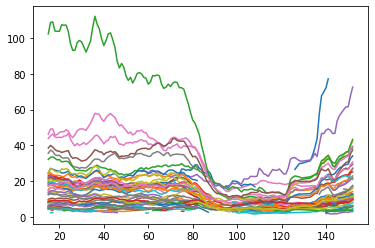

In [41]:
for name in station_names:
    plt.plot(by_station_2020_df[name].rolling(window=15).mean())

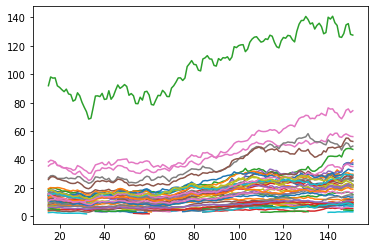

In [42]:
for name in station_names:
    plt.plot(by_station_2019_df[name].rolling(window=15).mean())

In [55]:
by_station_2020_fraction=pd.DataFrame()
for name in station_names:
    by_station_2020_fraction[name]=by_station_2020_df[name]/by_station_2019_df[name]

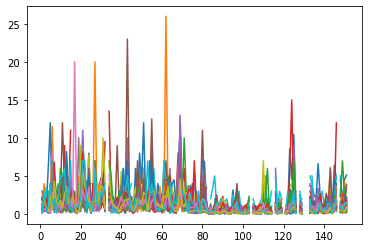

In [56]:
for name in station_names:
    plt.plot(by_station_2020_fraction[name])

In [70]:
station_location_df=bike_2020_df.groupby(['start station name'])[['start station latitude','start station longitude']].max().reset_index()

In [66]:
station_location_df.columns=['station','latitude','longitude']
station_location_df.groupby(['station'])[['latitude','longitude']]
#station_location={}
#for name in station_names:
#    latitude =
#    station_location[name]=station_location_df[station_location_df['station']==name]['latitude']

In [54]:
latitude_list=[]
longitude_list=[]
for name in station_names:
    change_in_number_of_trips = int(by_station_2020_fraction['name']*10)
    latitude_list.append(list(station_location[name])*change_in_number_of_trips

,station,latitude,longitude
0,5 Corners Library,40.734961,-74.059503
1,Astor Place,40.719282,-74.071262
2,Baldwin at Montgomery,40.723659,-74.064194
3,Bergen Ave,40.722104,-74.071455
4,Brunswick & 6th,40.726012,-74.050389
5,Brunswick St,40.724176,-74.050656
6,Christ Hospital,40.734786,-74.050444
7,City Hall,40.717733,-74.043845
8,Columbus Dr at Exchange Pl,40.716870,-74.032810
9,Columbus Drive,40.718355,-74.038914


In [68]:
station_location_df

,start station latitude,start station longitude
start station name,,
5 Corners Library,40.734961,-74.059503
Astor Place,40.719282,-74.071262
Baldwin at Montgomery,40.723659,-74.064194
Bergen Ave,40.722104,-74.071455
Brunswick & 6th,40.726012,-74.050389
Brunswick St,40.724176,-74.050656
Christ Hospital,40.734786,-74.050444
City Hall,40.717733,-74.043845
Columbus Dr at Exchange Pl,40.716870,-74.032810
